In [1]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library.standard_gates import MCXGate
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [3]:
def oracle(qc, nodes_qubits, edge_anc):
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])
    for i in range(1,3):
        qc.mct([nodes_qubits[edges[i][0] ], nodes_qubits[edges[i][1] ], edge_anc[0]], edge_anc[1])
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
    for i in range(3, len(edges)):
        qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0], edge_anc[1]], edge_anc[2])
        qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0]], edge_anc[1])
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0])
        
def reverse_oracle(qc, nodes_qubits, edge_anc):
    for i in range(len(edges)-1, 2, -1):
        qc.ccx(nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0]], edge_anc[1])
        qc.mct([nodes_qubits[edges[i][0]], nodes_qubits[edges[i][1]], edge_anc[0], edge_anc[1]], edge_anc[2])

    for i in range(2, 0, -1):
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1])
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])

In [4]:
# PROBLEMS: NUMBER OF EDGES HAS TO BE MORE THAN 4

# from: https://upload.wikimedia.org/wikipedia/commons/thumb/3/3d/Brute_force_Clique_algorithm.svg/1024px-Brute_force_Clique_algorithm.svg.png
# 1 4-clique
n_nodes = 7
edges = [(0, 1), (0, 4), (0, 6), (0, 3), (1, 2), (1, 5), (1, 4), (2, 5), (2, 6), (2, 3), (3, 6), (3, 4), (4, 6), (4, 5), (5, 6)] 

# multiple 4-cliques 
# edges = [(0, 1), (0, 4), (0, 6), (0, 3), (1, 2), (1, 5), (1, 4), (2, 5), (2, 6), (2, 3), (3, 6), (3, 4), (4, 6), (4, 5), (5, 6), (1, 6)] # just added (1, 6) edge

In [5]:
# all the combinations of 0 and 1 of size n_nodes
lst = list(itertools.product([0, 1], repeat=n_nodes))
# the combinations where sum = 4 (number of nodes in a claw)
sum_four_tuples = [a for a in lst if sum(a) == 4]
# convert int tuple to string
sum_four_states = [''.join(map(str, a)) for a in sum_four_tuples]
len(sum_four_states), sum_four_states

(35,
 ['0001111',
  '0010111',
  '0011011',
  '0011101',
  '0011110',
  '0100111',
  '0101011',
  '0101101',
  '0101110',
  '0110011',
  '0110101',
  '0110110',
  '0111001',
  '0111010',
  '0111100',
  '1000111',
  '1001011',
  '1001101',
  '1001110',
  '1010011',
  '1010101',
  '1010110',
  '1011001',
  '1011010',
  '1011100',
  '1100011',
  '1100101',
  '1100110',
  '1101001',
  '1101010',
  '1101100',
  '1110001',
  '1110010',
  '1110100',
  '1111000'])

In [6]:
def grover():
    node_qubits = QuantumRegister(n_nodes, name='n')
    vertex_flag = QuantumRegister(1, name='is_four_ones')
    e_qubits = QuantumRegister(3, name='e')
    flag_qubit = QuantumRegister(1, name="flag")
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    qc = QuantumCircuit(node_qubits, vertex_flag, e_qubits, flag_qubit, class_bits)
    # Initialize qunatum flag qubits in |-> state. i.e. qc.initialize([1, -1]/np.sqrt(2), flag_qubit)
    qc.x(flag_qubit)
    qc.h(flag_qubit)
    
    # Initializing i/p qubits in superposition
    qc.h(node_qubits)
    qc.barrier()

    num_iterations = n_nodes - 1 # arbritary
    for i in range(num_iterations):
        # 1
        for sum_four_state in sum_four_states:
            qc.append(MCXGate(n_nodes, ctrl_state=sum_four_state), node_qubits[:] + vertex_flag[:])
        
        # 2
        oracle(qc, node_qubits, e_qubits)

        # here, 6 := 110 (i.e. equbits 2 and 1 should be 1)
        qc.mct([vertex_flag, e_qubits[1], e_qubits[2]], flag_qubit)    

        # 2 reverse
        reverse_oracle(qc, node_qubits, e_qubits)
        
        # 1 reverse
        for sum_four_state in sum_four_states[::-1]:
            qc.append(MCXGate(n_nodes, ctrl_state=sum_four_state), node_qubits[:] + vertex_flag[:])    

        qc.barrier()
        qc.append(diffuser(n_nodes), node_qubits)
    
    qc.measure(node_qubits,class_bits)
    return qc

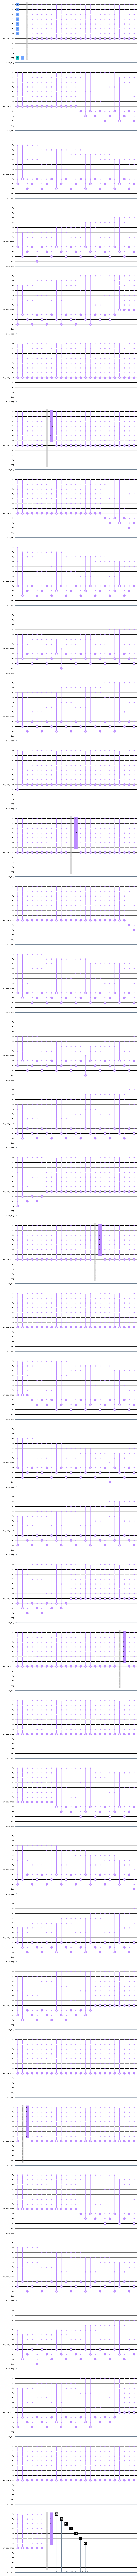

In [7]:
qc = grover()
qc.draw()

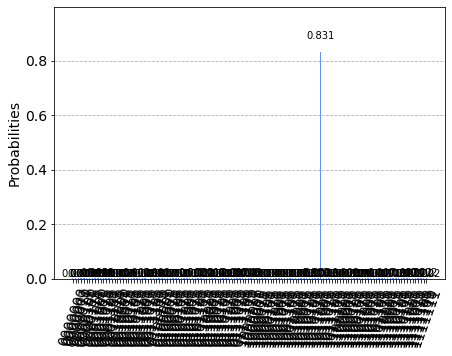

In [8]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(qc, simulator, shots=10000)
result = job.result()
counts = result.get_counts(qc)
plot_histogram(counts)

In [9]:
{k: v for k, v in sorted(counts.items(), key=lambda item: item[1], reverse=True)}

{'1011001': 8311,
 '0011110': 23,
 '0101011': 22,
 '1110111': 21,
 '0111110': 21,
 '0111111': 21,
 '1011000': 21,
 '0110010': 20,
 '1010111': 19,
 '0111010': 19,
 '0001010': 19,
 '0010111': 18,
 '1100010': 18,
 '1111110': 18,
 '1101111': 18,
 '0001000': 18,
 '0101110': 18,
 '1111100': 18,
 '1110010': 17,
 '0001001': 17,
 '0110111': 17,
 '1111101': 17,
 '1010110': 17,
 '1101101': 17,
 '0000011': 17,
 '0010010': 17,
 '1101010': 17,
 '0111101': 17,
 '0100000': 17,
 '0010001': 17,
 '1001101': 17,
 '1001110': 17,
 '0110110': 16,
 '0000111': 16,
 '1010101': 16,
 '1100000': 16,
 '1100101': 16,
 '0111000': 16,
 '1100100': 15,
 '0000100': 15,
 '0100001': 15,
 '0011001': 15,
 '0101101': 15,
 '0000110': 15,
 '1111111': 15,
 '0011000': 15,
 '1011101': 15,
 '0100100': 15,
 '1010010': 15,
 '1011010': 15,
 '1000001': 14,
 '0000101': 14,
 '0100011': 14,
 '0001100': 14,
 '1100001': 14,
 '1100111': 14,
 '1011100': 14,
 '0010011': 14,
 '0001111': 14,
 '1111011': 13,
 '1101000': 13,
 '1110011': 13,
 '0001